<a href="https://colab.research.google.com/github/SanjayBhargavKudupudi/DM_Dimentionality_Reduction/blob/main/DataBricks/DataBricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c19630376f49ff0dde520893ca170ab50f5a2249ab48b7fab699abc7e3c63106
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Dimensionality_Reduction").getOrCreate()


In [3]:
# Upload the dataset file from your local system
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = spark.read.csv('/content/drive/MyDrive/DATA_MINING_DATASETS/youtubers_df.csv', header=True, inferSchema=True)
df.show()


Saving youtubers_df.csv to youtubers_df.csv
+----+--------------------+--------------------+-------------------+--------------+------------------+---------+--------+--------------------+
|Rank|            Username|          Categories|         Suscribers|       Country|            Visits|    Likes|Comments|               Links|
+----+--------------------+--------------------+-------------------+--------------+------------------+---------+--------+--------------------+
|   1|             tseries|      Música y baile|            2.495E8|         India|           86200.0|   2700.0|    78.0|http://youtube.co...|
|   2|             MrBeast|  Videojuegos, Humor|            1.835E8|Estados Unidos|           1.174E8|5300000.0| 18500.0|http://youtube.co...|
|   3|           CoComelon|           Educación|            1.655E8|       Unknown|         7000000.0|  24700.0|     0.0|http://youtube.co...|
|   4|            SETIndia|                NULL|            1.626E8|         India|           1560

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# Correct the column names based on your dataset
# Let's assume the correct names are 'Categories' and 'Country'

# 1. Handle missing values
df = df.fillna({'Categories': 'Unknown', 'Country': 'Unknown'})  # Fill missing values

# 2. Encode categorical variables
# String indexing for categorical variables
indexer = StringIndexer(inputCols=['Categories', 'Country'], outputCols=['CategoriesIndexed', 'CountryIndexed'])
df_indexed = indexer.fit(df).transform(df)

# One-hot encoding
encoder = OneHotEncoder(inputCols=['CategoriesIndexed', 'CountryIndexed'], outputCols=['CategoriesVec', 'CountryVec'])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# 3. Assemble all features into a single feature vector
# Add all your feature columns to the inputCols list
assembler = VectorAssembler(inputCols=['CategoriesVec', 'CountryVec', 'Suscribers', 'Visits', 'Likes', 'Comments'], outputCol='features')
df_assembled = assembler.transform(df_encoded)

# 4. Normalize the feature vector (if necessary)
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

# The resulting DataFrame 'df_scaled' is now ready for machine learning models in PySpark


In [8]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

# Configure PCA model
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")

# Apply PCA to the data
model = pca.fit(df_scaled)
result = model.transform(df_scaled)

# Select and show the result
result.select("pcaFeatures").show(truncate=False)


+---------------------------------------------+
|pcaFeatures                                  |
+---------------------------------------------+
|[2.0594186000980184,1.3970740718145662]      |
|[29.41847609766093,1.0084657441155669]       |
|[1.55545873865049,-0.5981207039510482]       |
|[1.0452516858275855,2.435843038238497]       |
|[0.27613734363053904,-1.9771561261775634]    |
|[2.157964787767684,-0.8947055053208156]      |
|[0.24334389351644423,-1.8994851175802832]    |
|[0.18704406218990285,-1.9871082409876863]    |
|[0.4114808461333422,1.2305315402107837]      |
|[1.309407815036086,-1.3759976520533685]      |
|[1.4708461567076878,-0.5843413629525467]     |
|[0.24797266455333242,2.3549549704323947]     |
|[0.12054137808156824,0.7786525593148327]     |
|[0.18797472993965716,1.150959831055734]      |
|[1.0051294879180537,1.2229904358381203]      |
|[0.827825661392131,-0.6251283776071278]      |
|[0.05497208647346887,2.3356052766035362]     |
|[-0.6081578276514422,-2.054032827549072

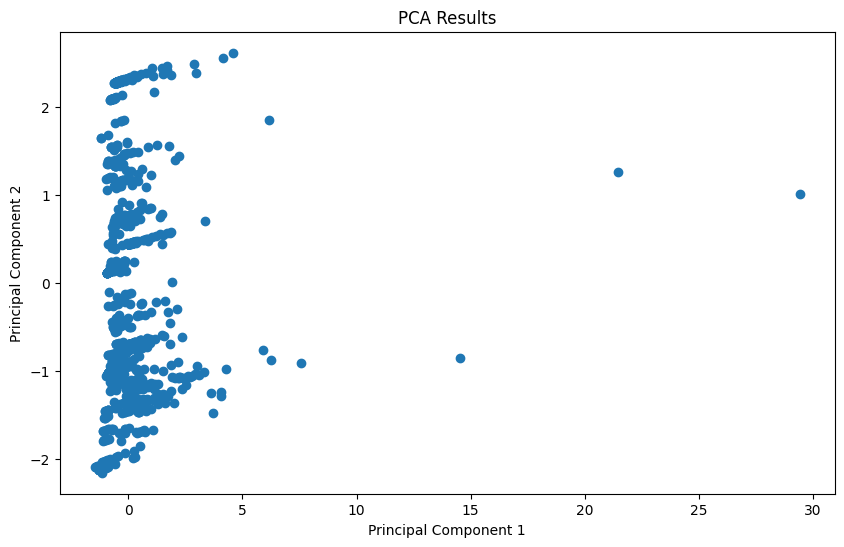

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
result_pandas = result.select("pcaFeatures").toPandas()

# Extract PCA components and plot
pca_features = result_pandas['pcaFeatures'].apply(lambda x: pd.Series(x.toArray()))
pca_features.columns = ['PC1', 'PC2']

plt.figure(figsize=(10, 6))
plt.scatter(pca_features['PC1'], pca_features['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results')
plt.show()


In [10]:
from pyspark.ml.clustering import KMeans

# Configure KMeans model
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("pcaFeatures")

# Apply KMeans to the PCA results
model = kmeans.fit(result)
clusters = model.transform(result)

# Show cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[21.79785931  0.47216222]
[-0.12526759  1.37680296]
[-0.02161218 -1.01708038]


In [11]:
spark.stop()
